In [8]:
import os
from glob import glob
import warnings

from netCDF4 import Dataset
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from rasterstats import zonal_stats
import shapefile
import pandas as pd
import geopandas as gpd

from pysteps.visualization import plot_precip_field
import pyart

import common
import mesh
warnings.simplefilter("ignore")

In [17]:
#to run:
#update paths for vol and output
#update radar id and date
#update reflectivity offset (remember that it's +)

#source zip
radar_id = '40'
date_str = '20200120'
vol_zip_ffn = f'/g/data/rq0/level_1/odim_pvol/{radar_id}/{date_str[0:4]}/vol/{radar_id}_{date_str}.pvol.zip'
vol_dbz_offset = 3.6 #GR-SR
#gridding
grid_config  = {'GRID_SHAPE': (41, 301, 301),
                'GRID_STEP': 1000,
                'GRID_LIMITS': ((0, 20000), (-150000.0, 150000.0), (-150000.0, 150000.0)),
                'GRID_ROI': 2500,
                'radar_id_str': radar_id}

#skip processing <-- remove this limit
upper_limit = 100

#cresta
cresta_ffn = '/g/data/kl02/jss548/PERILS/cresta_2019/cresta_2019_hi_res_AUS_GDA3577.shp'

#output
output_root = '/g/data/kl02/jss548/PERILS/case_outputs'
output_path = f'{output_root}/{radar_id}/{date_str}'
common.mkdir(output_path)

In [18]:
#step 1: vols -> mesh/refl grids -> daily nc

#extract volumes
temp_path = common.unpack_zip(vol_zip_ffn)
vol_ffn_list = sorted(glob(temp_path + '/*.h5'))

#grid and retrieve mesh
#create dims for file
T_DIM = len(vol_ffn_list)
Y_DIM = grid_config['GRID_SHAPE'][1]
X_DIM = grid_config['GRID_SHAPE'][2]
#init daily mesh/refl
mesh_daily = np.zeros((T_DIM, Y_DIM, X_DIM))
refl_daily = np.zeros((T_DIM, Y_DIM, X_DIM))
is_file = np.zeros((T_DIM))

for i, vol_ffn in tqdm(enumerate(vol_ffn_list[0:upper_limit]), total=len(vol_ffn_list[0:upper_limit])):
    mesh_data, mesh_meta, refl_data, refl_meta = common.vol_to_grids(vol_ffn, grid_config, vol_dbz_offset)
    mesh_daily[i, :, :] = mesh_data.filled(0)
    refl_daily[i, :, :] = refl_data.filled(-999)
    is_file[i] = True

#write to nc file
dt_list = common.get_dt_list(vol_ffn_list)
projparams = common.get_projparams(vol_ffn_list[0])
mesh_nc_ffn = common.write_netcdf(dt_list, output_path, grid_config, mesh_daily, 'mesh', mesh_meta, {}, is_file, projparams, fillvalue=-32768)
refl_nc_ffn = common.write_netcdf(dt_list, output_path, grid_config, refl_daily, 'refl', refl_meta, {}, is_file, projparams, fillvalue=-32768)

#clean up
os.system('rm -rf ' + temp_path)
print('finished step 1')

100%|██████████| 100/100 [05:52<00:00,  3.52s/it]


finished step 1


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


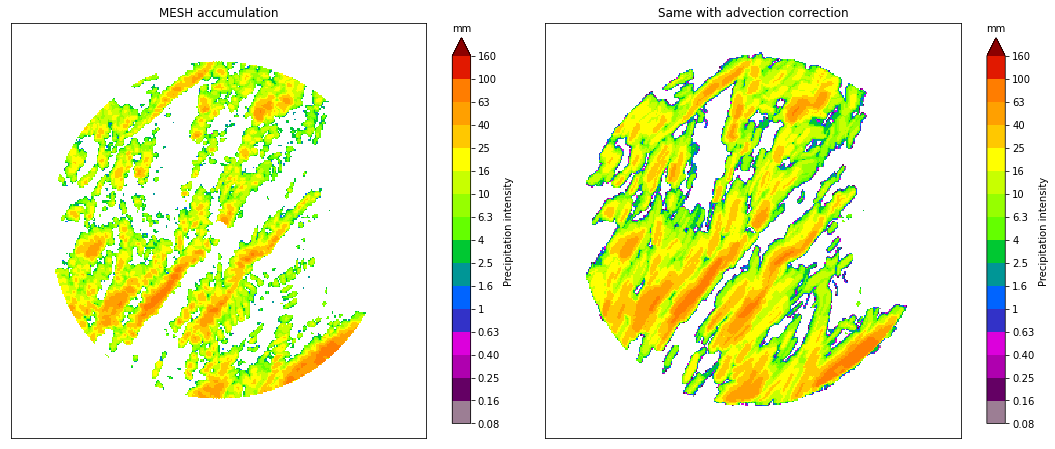

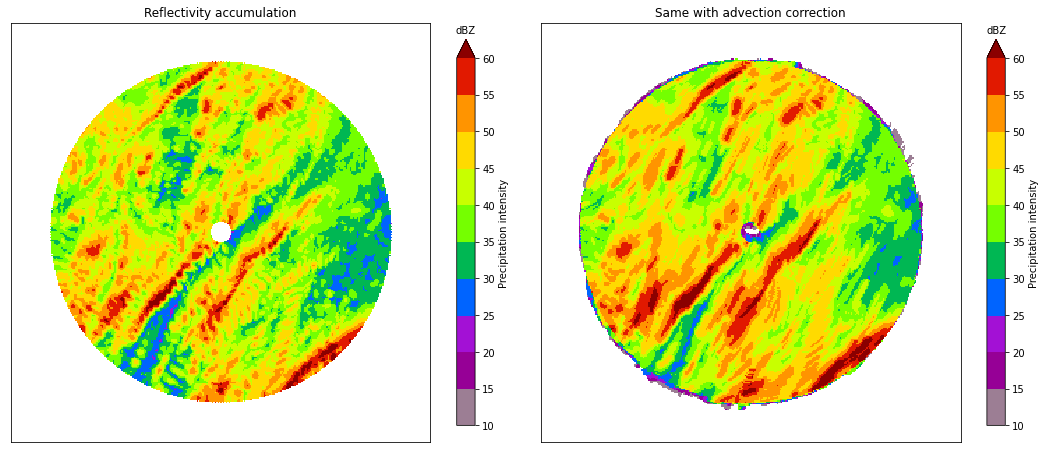

finished step 2


In [19]:
#mesh_nc_ffn = '/g/data/kl02/jss548/PERILS/case_outputs/02/20200119/02_20200119_MESH.nc'
#refl_nc_ffn = '/g/data/kl02/jss548/PERILS/case_outputs/02/20200119/02_20200119_REFL.nc'

#step 2: daily nc -> advection corrected geotif
basename_ffn = mesh_nc_ffn[:-8]

#load data from nc
mesh_ncid = Dataset(mesh_nc_ffn)
refl_ncid = Dataset(refl_nc_ffn)
daily_mesh = mesh_ncid.variables['mesh'][:]
daily_refl = refl_ncid.variables['refl'][:]
time_array = refl_ncid.variables['time'][:]
mesh_swath = np.amax(daily_mesh, axis=0)
refl_swath = np.amax(daily_refl, axis=0)
#create geoinfo for geotif
geo_info = {}
geo_info['radar_lat'] = np.mean(mesh_ncid.variables['latitude'][:])
geo_info['radar_lon'] =	np.mean(mesh_ncid.variables['longitude'][:])
geo_info['grid_dist'] = mesh_ncid.variables['x'][:][-1] #maximum grid range (km)
geo_info['grid_step'] = mesh_ncid.variables['x'][-1] - mesh_ncid.variables['x'][-2]
#vol timestep
timestep = int(np.round((time_array[1]-time_array[0])/60))

#advection correction
mesh_ac_swath = daily_mesh[0,:,:].copy()
refl_ac_swath = daily_refl[0,:,:].copy()
total = upper_limit#daily_mesh.shape[0] - 1
for i in tqdm(range(total), total=total):
    mesh_ac_swath = np.amax(np.stack((mesh_ac_swath, common.advection_correction(daily_mesh[i : (i + 2), :,:], T=timestep, t=1)), axis=2), axis=2)
    refl_ac_swath = np.amax(np.stack((refl_ac_swath, common.advection_correction(daily_refl[i : (i + 2), :,:], T=timestep, t=1)), axis=2), axis=2)
#R_ac /= daily_mesh.shape[0]

#plot mesh
plt.figure(figsize=(15, 7))
plt.subplot(121)
plot_precip_field(mesh_swath, title="MESH accumulation", units='mm')
plt.subplot(122)
plot_precip_field(mesh_ac_swath, title="Same with advection correction", units='mm')
plt.tight_layout()
plt.savefig(basename_ffn+'.mesh.png', dpi=100)
plt.show()

#plot refl
plt.figure(figsize=(15, 7))
plt.subplot(121)
plot_precip_field(refl_swath, title="Reflectivity accumulation", units='dBZ')
plt.subplot(122)
plot_precip_field(refl_ac_swath, title="Same with advection correction", units='dBZ')
plt.tight_layout()
plt.savefig(basename_ffn+'.refl.png', dpi=100)
plt.show()

#write geotifs
refl_geotif_ffn = basename_ffn + '.refl.tif'
mesh_geotif_ffn = basename_ffn + '.mesh.tif'
mesh_20mm_geotif_ffn = basename_ffn + '.mesh_20mm.tif'
mesh_50mm_geotif_ffn = basename_ffn + '.mesh_50mm.tif'
mesh_thresholds_shp_ffn = basename_ffn + '.mesh_thresholds.shp'

#create 20 and 50mm fields
mesh_20mm_ac_swath = mesh_ac_swath>=20
mesh_50mm_ac_swath = mesh_ac_swath>=50
#save to geotif
common.write_grid_geotiff(refl_ac_swath, refl_geotif_ffn, geo_info,
                   vmin=0, vmax=70)
common.write_grid_geotiff(mesh_ac_swath, mesh_geotif_ffn, geo_info,
                   vmin=0, vmax=150)
common.write_grid_geotiff(mesh_20mm_ac_swath, mesh_20mm_geotif_ffn, geo_info,
                   vmin=0, vmax=1) #not used, replaced with shapefile below
common.write_grid_geotiff(mesh_50mm_ac_swath, mesh_50mm_geotif_ffn, geo_info,
                   vmin=0, vmax=1) #not used, replaced with shapefile below

#write shapefile for mesh thresholds
mesh_levels = '20 50'
#use gdal contour to create contour plots
cmd = f'gdal_contour -a level {mesh_geotif_ffn} {mesh_thresholds_shp_ffn} -fl {mesh_levels} -p'
os.system(cmd)

print('finished step 2')

In [20]:
#step 3: zontal statistics
cresta_data = shapefile.Reader(cresta_ffn)

stats_refl = zonal_stats(cresta_ffn, 
                    refl_geotif_ffn,
                    copy_properties = True,
                    prefix = "refl_",
                    stats ="mean max")
stats_mesh = zonal_stats(cresta_ffn, 
                    mesh_geotif_ffn,
                    copy_properties = True,
                    prefix = "mesh_",
                    stats ="mean max")
# stats_mesh_20mm = zonal_stats(cresta_ffn, 
#                     mesh_20mm_geotif_ffn,
#                     prefix = "mesh_20mm_",
#                     stats ="sum")
# stats_mesh_50mm = zonal_stats(cresta_ffn, 
#                     mesh_50mm_geotif_ffn,
#                     prefix = "mesh_50mm_",
#                     stats ="sum")
#https://gis.stackexchange.com/questions/353788/locating-the-maximum-values-of-a-raster-intersection-with-a-vector-of-polygons-u

print('finished step 3')

finished step 3


In [21]:
#step 4, calculate intersection between cresta regions and mesh threshold polygons

#read shapefiles
cresta_fc = gpd.GeoDataFrame.from_file(cresta_ffn)
mesh_fc = gpd.GeoDataFrame.from_file(mesh_thresholds_shp_ffn)
# #convert to epsg that uses m as the coordinate system
cresta_fc_m = cresta_fc.copy().to_crs({'init': 'epsg:3577'}) #GDA projection
mesh_fc_m = mesh_fc.copy().to_crs({'init': 'epsg:3577'})

# res_intersection = gpd.overlay(cresta_fc_m, mesh_fc_m, how='intersection')
# print(res_intersection)

#for every cresta polygon, accumulate the area of any overlapping mesh polygons for 20 and 50mm
area_20mm_list = []
area_50mm_list = []
for index, cresta in cresta_fc_m.iterrows():
    area_20mm_acc = 0
    area_50mm_acc = 0
    for index2, mesh in mesh_fc_m.iterrows():
        if cresta['geometry'].intersects(mesh['geometry']):
            temp_area = cresta['geometry'].intersection(mesh['geometry']).area
            if mesh['ID']==1 and temp_area is not None: #intersect for ID 1 (20mm)
                area_20mm_acc += np.abs(temp_area/ 10**6)
            elif mesh['ID']==2 and temp_area is not None: #intersect for ID 2 (50mm)
                area_50mm_acc += np.abs(temp_area/ 10**6)    
    area_20mm_acc = np.array(area_20mm_acc)
    area_50mm_acc = np.array(area_50mm_acc)
    area_20mm_list.append(area_20mm_acc+area_50mm_acc) #important, because 50mm polygons are cutout of 20mm polygons
    area_50mm_list.append(area_50mm_acc)

print('finished step 4')

finished step 4


In [22]:
#compile and output as csv

#compile in dictionary
cresta_id_list = []
cresta_area = []
max_mesh_list = []
mean_mesh_list = []
max_refl_list = []
mean_refl_list = []

#compile data into lists
for i in range(len(stats_refl)):
    cresta_record = cresta_data.record(i)
    cresta_id_list.append(cresta_record[0])
    cresta_area.append(cresta_record[11])
    max_refl_list.append(stats_refl[i]['refl_max'])
    mean_refl_list.append(stats_refl[i]['refl_mean'])
    max_mesh_list.append(stats_mesh[i]['mesh_max'])
    mean_mesh_list.append(stats_mesh[i]['mesh_mean'])

#remove none from lists
max_refl_list = [0.0 if v is None else v for v in max_refl_list]
mean_refl_list = [0.0 if v is None else v for v in mean_refl_list]
max_mesh_list = [0.0 if v is None else v for v in max_mesh_list]
mean_mesh_list = [0.0 if v is None else v for v in mean_mesh_list]

#convert data to dictionary
data_dict = {'CRESTA_ID':cresta_id_list, 'CRESTA_Area_(km2)':cresta_area,
             'Maximum_MESH_(mm)':max_mesh_list, 'Mean_MESH_(mm)':mean_mesh_list,
            'Max_Reflectivity_(dBZ)': max_refl_list, 'Mean_Reflectivity_(dBZ)':mean_refl_list,
            'Area_of_20mm_MESH(km2)':area_20mm_list, 'Area_of_50mm_MESH(km2)':area_50mm_list}
#write to csv
df = pd.DataFrame.from_dict(data_dict)
data_csv_ffn = basename_ffn + '.output.csv'
df.to_csv(data_csv_ffn, index=False)

print('finished step 5')

finished step 5
